In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [43]:
## image normalization
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [44]:
## Data normalization and augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [45]:
print(data_transforms)

{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
), 'val': Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
), 'test': Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
)}


In [48]:
## data
data_dir = "/content/drive/My Drive/Colab Notebooks/datasets and models/dataset (1)"
sets = ["train", "val", "test"]
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val", "test"]}

In [49]:
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: /content/drive/My Drive/Colab Notebooks/datasets and models/dataset (1)/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: /content/drive/My Drive/Colab Notebooks/datasets and models/dataset (1)/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 4
    Root location: /content/drive/My Drive/Colab Notebooks/d

In [50]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}

In [51]:
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fb471bdee48>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fb471b91ac8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fb471b91eb8>}


In [52]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [53]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [54]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

torch.Size([4, 3, 224, 224])


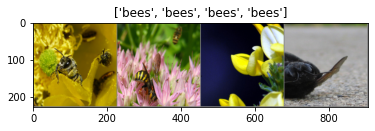

In [55]:
imshow(out, title=[class_names[x] for x in classes])

## Model Building

 ## First approach.
 #### Finetuning the convnet
 #### Load a pretrained model and reset final fully connected layer.

In [16]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7071 Acc: 0.5287
val Loss: 0.5456 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.5555 Acc: 0.7459
val Loss: 0.3977 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4876 Acc: 0.7869
val Loss: 0.3127 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4747 Acc: 0.7869
val Loss: 0.2683 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4028 Acc: 0.8361
val Loss: 0.2358 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4050 Acc: 0.8115
val Loss: 0.2177 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4060 Acc: 0.8197
val Loss: 0.2299 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3586 Acc: 0.8566
val Loss: 0.2122 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3564 Acc: 0.8320
val Loss: 0.2208 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3463 Acc: 0.8443
val Loss: 0.2094 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3310 Acc: 0.8566
val Loss: 0.2176 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3156 Acc: 0.8770
val Loss: 0.2131 Acc: 0.9281

Ep

In [ ]:
torch.save(model.state_dict(), "fine_tuning_24epochs.pth")

In [19]:
model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/datasets and models/fine_tuning_24epochs.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([4, 3, 224, 224])


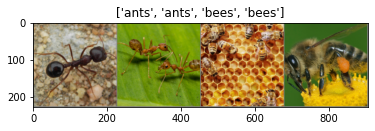

In [63]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['test']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in labels]) # ants = 0, bees = 1

In [64]:
inputs = inputs.to(device)
labels = labels.to(device)

In [65]:
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

In [67]:
predicted_labels = [class_names[x] for x in preds]

In [68]:
print(predicted_labels)

['ants', 'ants', 'bees', 'bees']


 ## Second approach.
 #### ConvNet as fixed feature extractor
 ##### Here, we need to freeze all the network except the final layer.
##### We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

In [69]:
model = models.resnet18(pretrained=True)
for param in  model.parameters():
    param.requires_grad = False
    
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [70]:
num_features = model.fc.in_features

In [71]:
print(num_features)

512


In [72]:
model.fc = nn.Linear(in_features=num_features, out_features=2)
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
## loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [74]:
## scheduler
step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.1)

### Training loop

In [75]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model = train(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7052 Acc: 0.5164
val Loss: 0.5761 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.5720 Acc: 0.7377
val Loss: 0.4916 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.4737 Acc: 0.8484
val Loss: 0.3780 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4790 Acc: 0.7951
val Loss: 0.3634 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4701 Acc: 0.7910
val Loss: 0.3229 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4704 Acc: 0.7951
val Loss: 0.3165 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4370 Acc: 0.8361
val Loss: 0.2907 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4278 Acc: 0.8238
val Loss: 0.2908 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4123 Acc: 0.8484
val Loss: 0.2682 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4235 Acc: 0.8033
val Loss: 0.2707 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.4160 Acc: 0.8484
val Loss: 0.2828 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4113 Acc: 0.8156
val Loss: 0.2881 Acc: 0.9281

Ep

In [ ]:
torch.save(model.state_dict(),"fc_25epochs.pth" )

In [76]:
model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/datasets and models/fc_25epochs.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([4, 3, 224, 224])


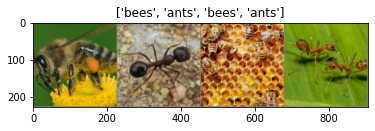

In [77]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['test']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in labels]) # ants = 0, bees = 1

In [78]:
inputs = inputs.to(device)
labels = labels.to(device)

In [79]:
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

In [80]:
predicted_labels = [class_names[x] for x in preds]

In [81]:
print(predicted_labels)

['bees', 'ants', 'bees', 'ants']
